## Covid19 Projection
The purpose of this notebook is to run Covid-19 case projections at State or Country levels. The outcome is the projection of the total confirmed cases for the target geography. 

This solution first tries to understand the approximate time to peak for the target entity (state/country), expected case rates and higher/lower bounds. It determines these parameters from countries that have exhibited similar trends in the past. 

Next, it determines the best simulation parameters in terms of transmission probability and weeks to peak by running the simulator iteratively with values from a parameter space.

Finally, it runs a simulation with the optimized parameters to generate day by day case projections. The simulation assumes 2 waves of infection surges following gaussian distribution and tries to apply that in generating the case projections. It also incorporates various factors like transmission probability, testing efficiency, intervention impacts etc.

Note: interventions_scorer.ipynb should be excuted prior to running the projections on new data

In [1]:
!pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import sys
sys.path.insert(1, 'src')
import pandas as pd
import numpy as np
import random
import config
import state_data_loader
import country_data_loader
import urllib.request
import os
# fixed_seed = 39
# random.seed(fixed_seed)
# np.random.seed(fixed_seed)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from simulation_orchestrator import run

This simulation works best for a timeline when the infection is trending upward, i.e. it is able to find a greater than 1 transmission-rate and a postive time-to-peak from the recent data. As samples, we have used a few states from India and USA as the country for demonstration.

### Fetch latest data for target States / Countries

In [3]:
# Set this flag to True if you want to download the latest COVID19 cases data from respective web sources
LOAD_LATEST_DATA = True


In [4]:
target_states = ['KL', 'MH']
# Transform and write the Indian states specific data for further processing
state_data_loader.load('India', target_states)


Processing data for state: KL  * * * * * * * * * *
Processing data for state: MH  * * * * * * * * * *


### Important parameters:

##### future projection_days
- Number of days to project confirmed COVID19 cases for, including the test_days.

#### country_code, state, state_population, actual_testing_capacity
- Target location specific parameters
- state, state_population parameters to represent the target country when projecting for a country

##### These parameters should be configured based on the target location and current day before running the projections.

*** Additional configurable parameters can be managed in src/config.python

### Sample Projections for Indian States

Data Availability Timeline: 2020-03-14 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-07-02 00:00:00 | w1_peak_dt: None | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 3459.05 [0.010354558114469108 %]  |  Init Case Rt: 1047.25 [0.003134910158967859 %]
Case Rate: 1047.25, Incidence Rate: 0.00012539640635871437, Projection Population: 3000, Scaling Factor: 26.582666666666668
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (18, 22) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity'), Integer(low=18, high=22, prior='uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed:

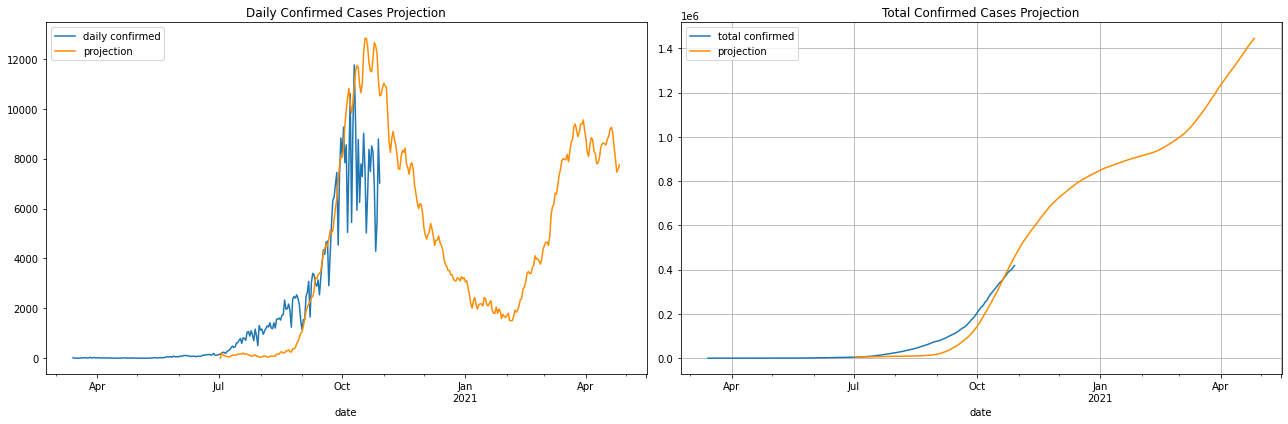



Simulation 2: using 50% end-to-end aggregated interventions:


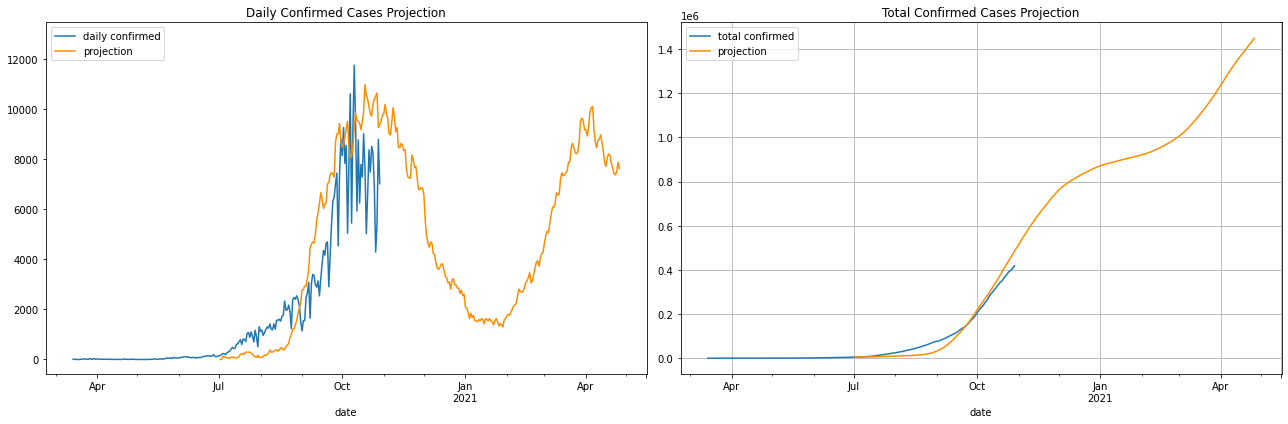



Simulation 3: using 90% end-to-end aggregated interventions:


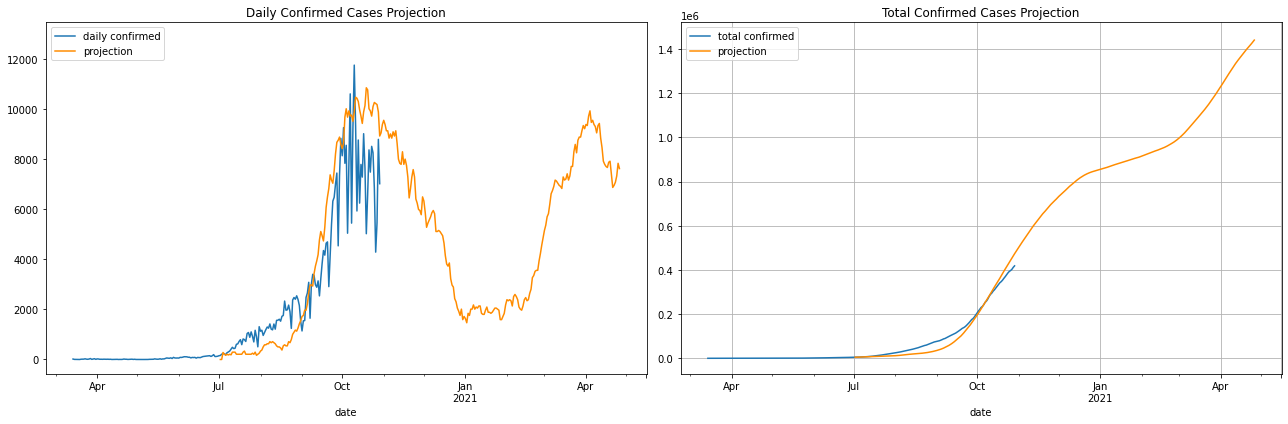

Total Time Taken: 0:06:53.658670


In [5]:
country_code, state, state_population, actual_testing_capacity = 'IND', 'KL', 33406061, 6000
future_projection_days = 180

run (country_code, state, state_population, actual_testing_capacity, future_projection_days)

Data Availability Timeline: 2020-03-14 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-04-27 00:00:00 | w1_peak_dt: 2020-09-14 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 7703.989361702128 [0.006855648577422149 %]  |  Init Case Rt: 1571.3000000000002 [0.0013982730380255074 %]
Case Rate: 1571.3000000000002, Incidence Rate: 9.987664557325051e-05, Projection Population: 3000, Scaling Factor: 33.37466666666667
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (19, 21) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 5075941726.609919


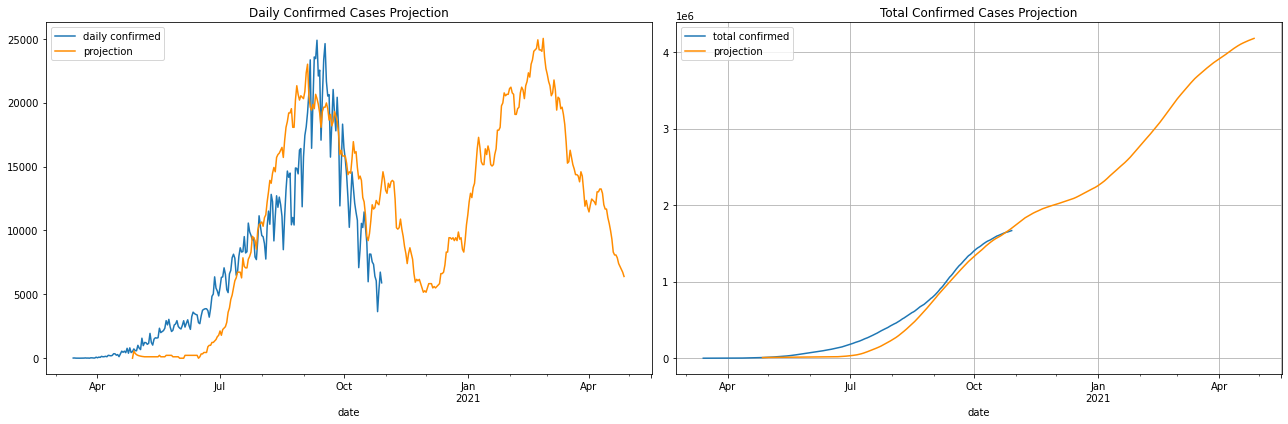



Simulation 2: using 50% end-to-end aggregated interventions:


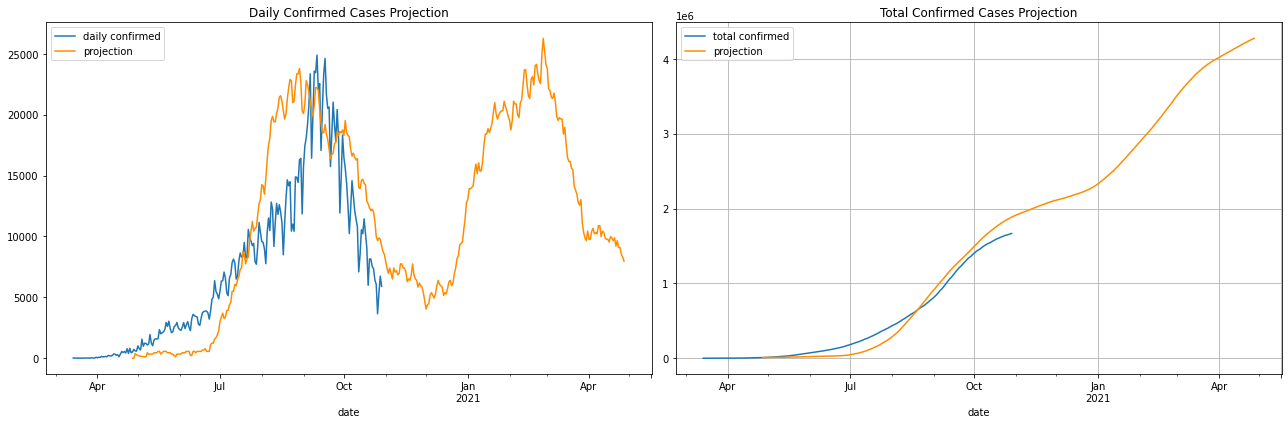



Simulation 3: using 90% end-to-end aggregated interventions:


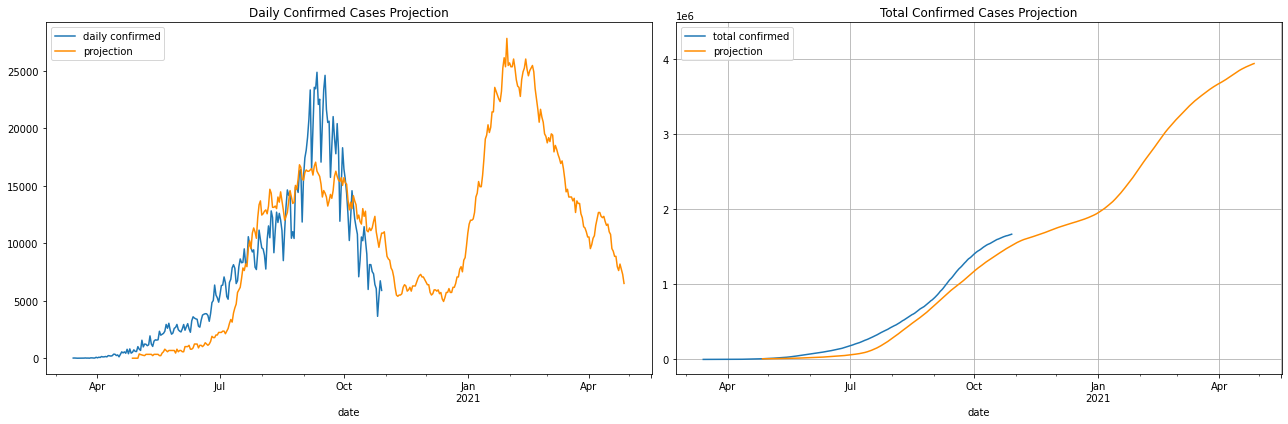

Total Time Taken: 0:10:54.426485


In [6]:
country_code, state, state_population, actual_testing_capacity = 'IND', 'MH', 112374333, 50000
future_projection_days = 180

run (country_code, state, state_population, actual_testing_capacity, future_projection_days)